In [1]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

import gfb_utils as g
import nsd_utils as n


In [2]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
# Loading a set of actual images

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn

n_samples = 5000
trn_stim_data = image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [4]:
# Parameters

n_ori = 8
n_sf = 3

# n_ori = 36
# n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [5]:
## Testing spatial version

n_images= 100
sample_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_spat))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

took 4.22 s to make filters
(100, 227, 227, 24)
total time is 12.91 s


In [6]:
## Testing frequency version

n_images= 100
sample_batch_size=2
filter_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_freq(bank, filter_batch_size, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_freq = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_freq))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

size of filter stack will be:
(635, 635, 24)
took 0.87 s to make filters
(100, 227, 227, 24)
total time is 2.06 s


In [7]:
# This is the version of the filtering code that came from NSD OSF repository

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import logspace

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    

x,y,sigma = [0,0,0.05]


In [8]:
# Get features using this method

n_images = 100
sample_batch_size=2
n_batches = int(np.ceil(n_images/sample_batch_size))
n_pixels = process_at_size[0]
n_features = len(_gaborizer.orients_deg)*len(_gaborizer.cyc_per_stim)

t_start = time.time()

for bb in range(n_batches):
    
    image_range = np.arange(bb*sample_batch_size, min((bb+1)*sample_batch_size, n_images),1)

    t = time.time()
    
    fmaps = _fmaps_fn(_to_torch(images[image_range],device=device))

    elapsed = time.time() - t
    
    if bb==0:
        maps_gab = [np.zeros(shape=(n_images, fm.shape[1], fm.shape[2], fm.shape[2])) for fm in fmaps]

    for sf in range(len(fmaps)):        
        maps_gab[sf][image_range,:,:,:] = fmaps[sf].cpu().detach().numpy()
    
print(np.shape(maps_gab[1]))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)


/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(100, 8, 62, 62)
total time is 0.48 s


In [10]:
# Get covariance matrices for features each method.
# first define a spatial rf
x,y,sigma=[-0.55, -0.55, 0.04]
sf2do = 1

n_pix_gab = maps_gab[sf2do].shape[2]
features_gab = get_features_in_prf([x,y,sigma], _fmaps_fn, images[0:n_images], sample_batch_size, aperture=1.0, device=device)
cov_gab = np.cov(np.transpose(features_gab))

In [11]:
n_pix_new = np.shape(maps_spat)[1]
prf_new = pnu.make_gaussian_mass(x, y, sigma, n_pix_new, size=1.0, dtype=fpX)[2]
features_spat = [np.tensordot(maps_spat[:,:,:,ff], prf_new, axes=[[1,2], [0,1]]) for ff in range(0,n_features)]
cov_spat = np.cov(features_spat)

In [12]:
n_pix_new = np.shape(maps_freq)[1]
prf_new = pnu.make_gaussian_mass(x, y, sigma, n_pix_new, size=1.0, dtype=fpX)[2]
features_freq = [np.tensordot(maps_freq[:,:,:,ff], prf_new, axes=[[1,2], [0,1]]) for ff in range(0,n_features)]
cov_freq = np.cov(features_freq)

Text(0, 0.5, 'trial')

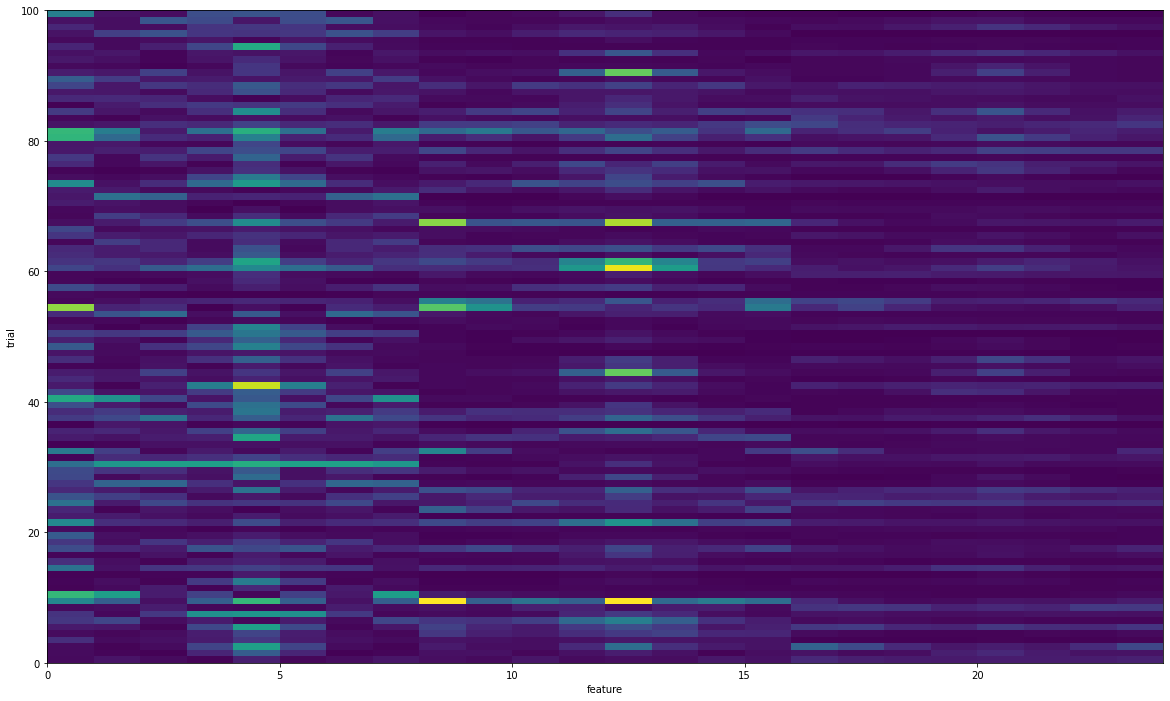

In [14]:

plt.figure(figsize=(20,12));
plt.pcolormesh(np.transpose(features_spat))
# plt.pcolormesh(np.transpose(features_freq))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')


Text(0, 0.5, 'trial')

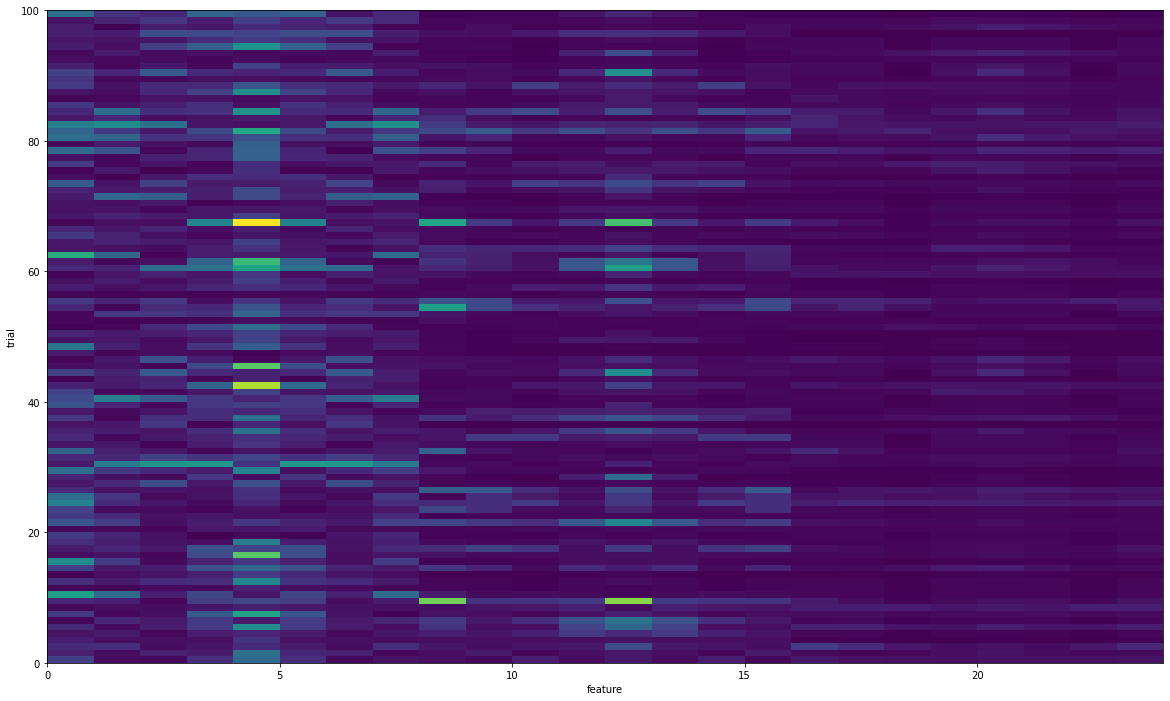

In [15]:
plt.figure(figsize=(20,12));
plt.pcolormesh(features_gab)
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('trial')


Text(0, 0.5, 'mean value across trials')

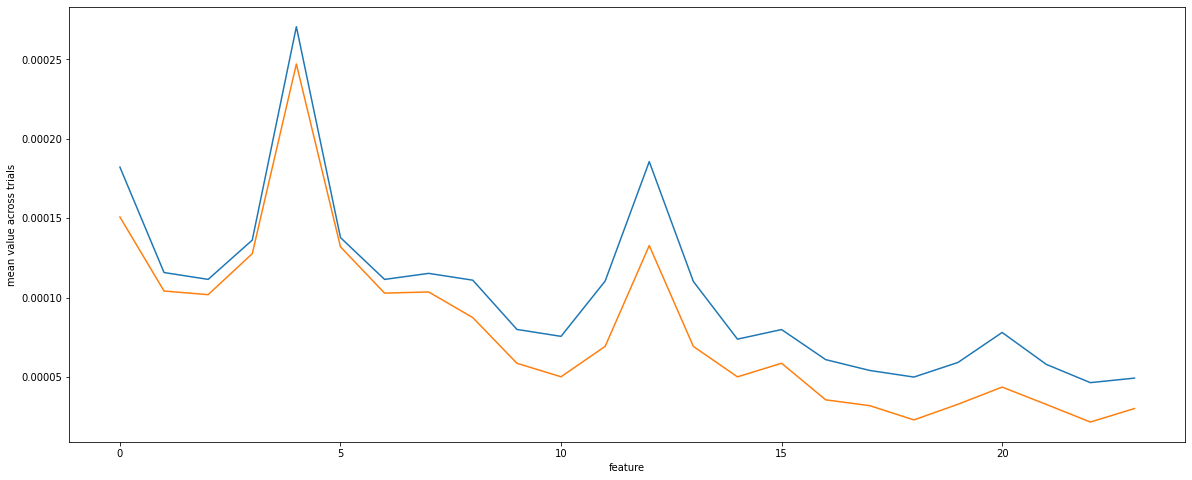

In [17]:
plt.figure(figsize=(20,8));
plt.plot(np.mean(np.transpose(features_spat),axis=0))
# plt.plot(np.mean(np.transpose(features_freq),axis=0))
plt.plot(np.mean(features_gab,axis=0))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
# plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('mean value across trials')

Text(0, 0.5, 'variance across trials')

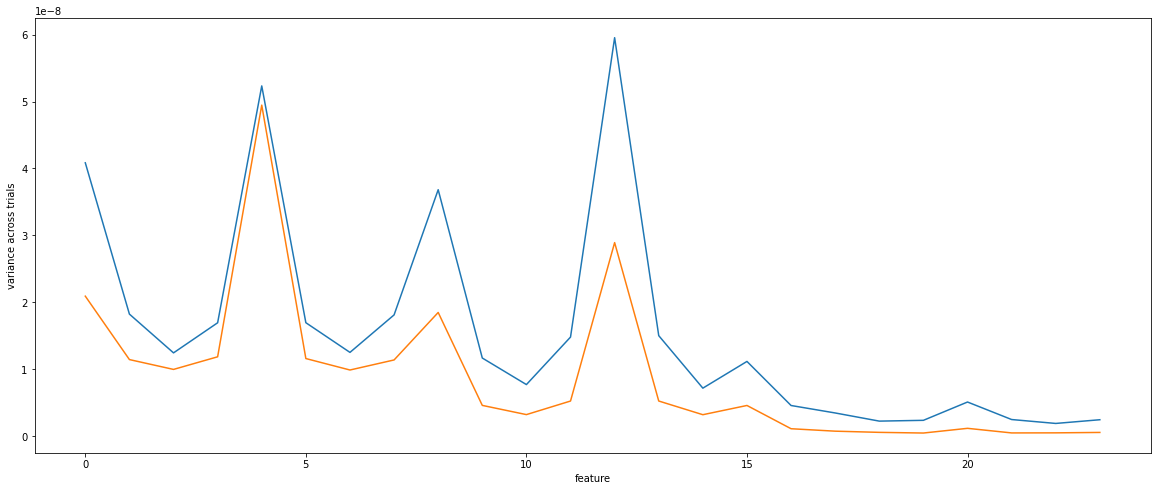

In [19]:
plt.figure(figsize=(20,8));
plt.plot(np.var(np.transpose(features_spat),axis=0))
# plt.plot(np.var(np.transpose(features_freq),axis=0))
plt.plot(np.var(features_gab,axis=0))
# for ii in np.arange(0,432,36):
#     plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
# plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('variance across trials')

([], [])

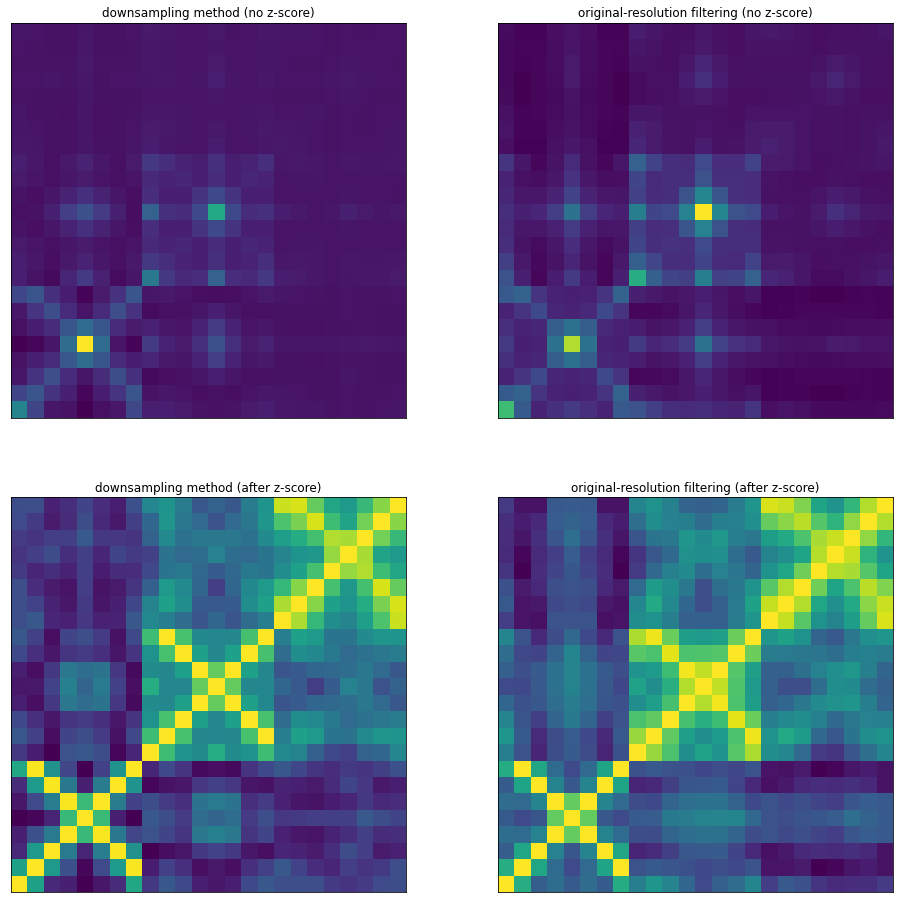

In [20]:
# Plot the covariance matrices together for comparison. 

import scipy

plt.figure(figsize=(16,16));
plt.subplot(2,2,1)
feat = features_gab
cov_gab = np.cov(np.transpose(feat))
plt.pcolormesh(cov_gab)
plt.axis('square')
plt.title('downsampling method (no z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2)
feat = features_spat
cov_spat = np.cov(feat)
plt.pcolormesh(cov_spat)
plt.axis('square')
plt.title('original-resolution filtering (no z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
feat = scipy.stats.zscore(features_gab,axis=0)
cov_gab = np.cov(np.transpose(feat))
plt.pcolormesh(cov_gab)
plt.axis('square')
plt.title('downsampling method (after z-score)')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
feat = scipy.stats.zscore(features_spat,axis=1)
cov_spat = np.cov(feat)
plt.pcolormesh(cov_spat)
plt.axis('square')
plt.title('original-resolution filtering (after z-score)')
plt.xticks([])
plt.yticks([])


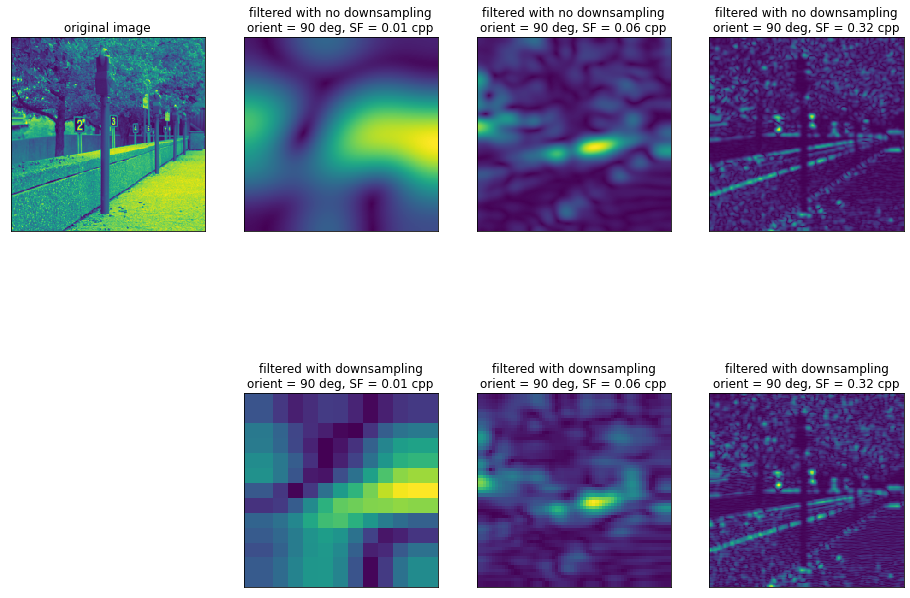

In [22]:
# Plotting all methods side by side

image_ind = 8

orient_labs = bank.orient_labs
a,orient_ind_list = np.unique(orient_labs,return_inverse=True)
freq_labs = bank.freq_labs
a,freq_ind_list = np.unique(freq_labs,return_inverse=True)

# a, orient_ind_list_old = np.unique(bank_old.orient_labs,return_inverse=True)
# a, freq_ind_list_old = np.unique(bank_old.freq_labs,return_inverse=True)

nFilts = len(orient_labs)

# ori2plot = (np.array([90,90,90])/5).astype('int')
# sf2plot = np.array([2,6,10]).astype('int')

ori2plot = (np.array([90,90,90])/(180/8)).astype('int')
sf2plot = np.array([0,1,2]).astype('int')



plt.figure(figsize=(16,12));

plt.subplot(2,4,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    ff = np.where(np.logical_and(orient_ind_list==ori2plot[ii], freq_ind_list==sf2plot[ii]))[0][0];

    plt.subplot(2,4,2+ii)
    plt.pcolormesh(maps_spat[image_ind,:,:,ff])
#     plt.pcolormesh(maps_freq[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered with no downsampling\norient = %d deg, SF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,4,6+ii)
    plt.pcolormesh(maps_gab[sf2plot[ii]][image_ind,ori2plot[ii],:,:])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered with downsampling\norient = %d deg, SF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])

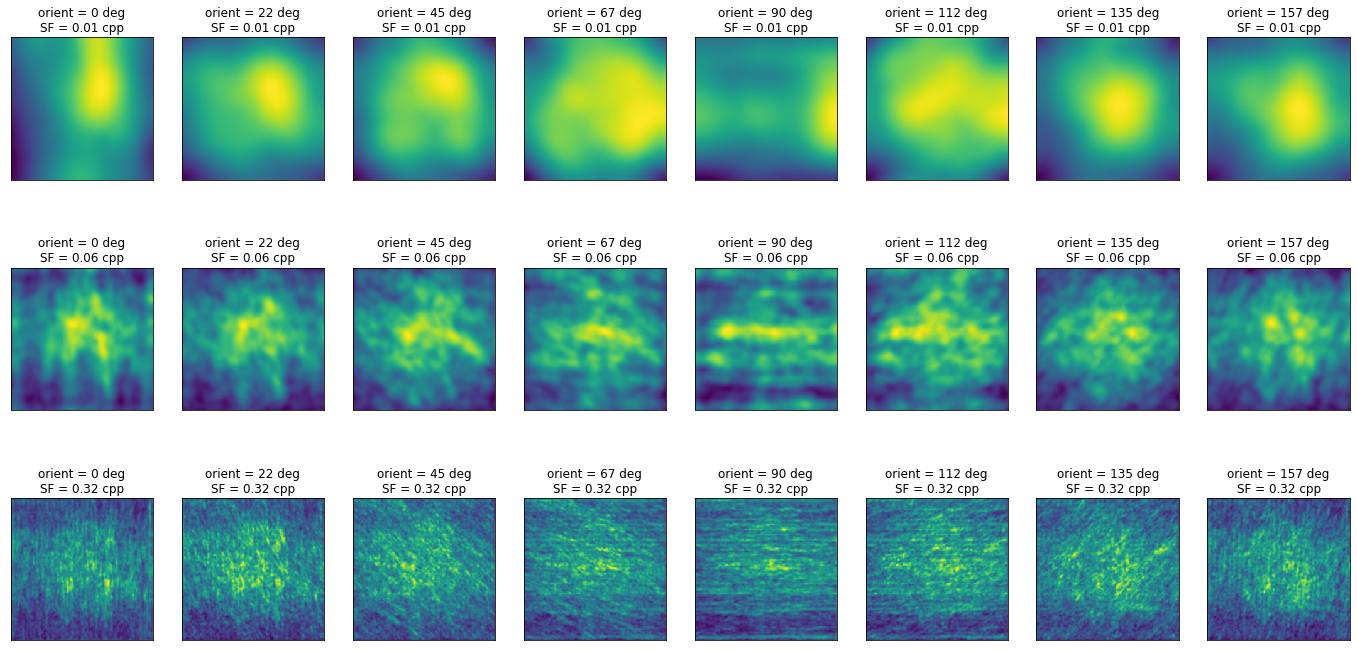

In [23]:
# plot average over maps for many images (want to see spatial distribution of energy)

plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_spat)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_spat[:,:,:,ff], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))

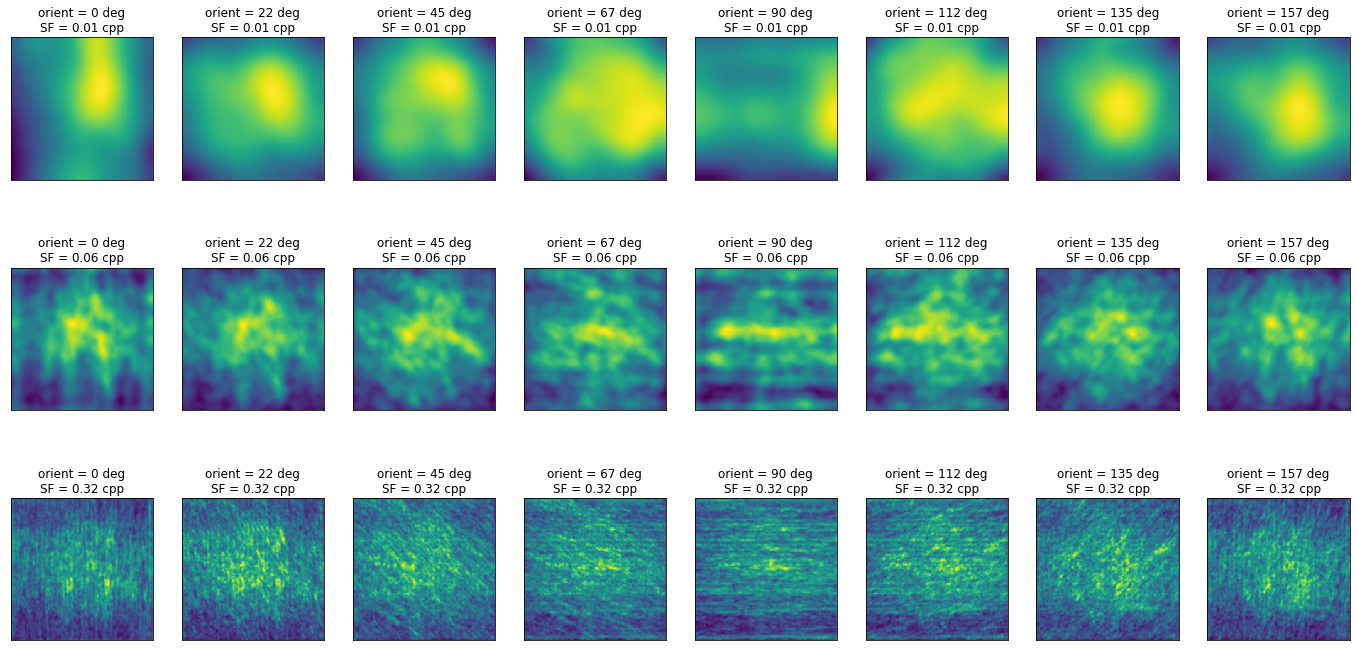

In [24]:
# plot average over maps for many images (want to see spatial distribution of energy)

plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_freq)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_freq[:,:,:,ff], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))

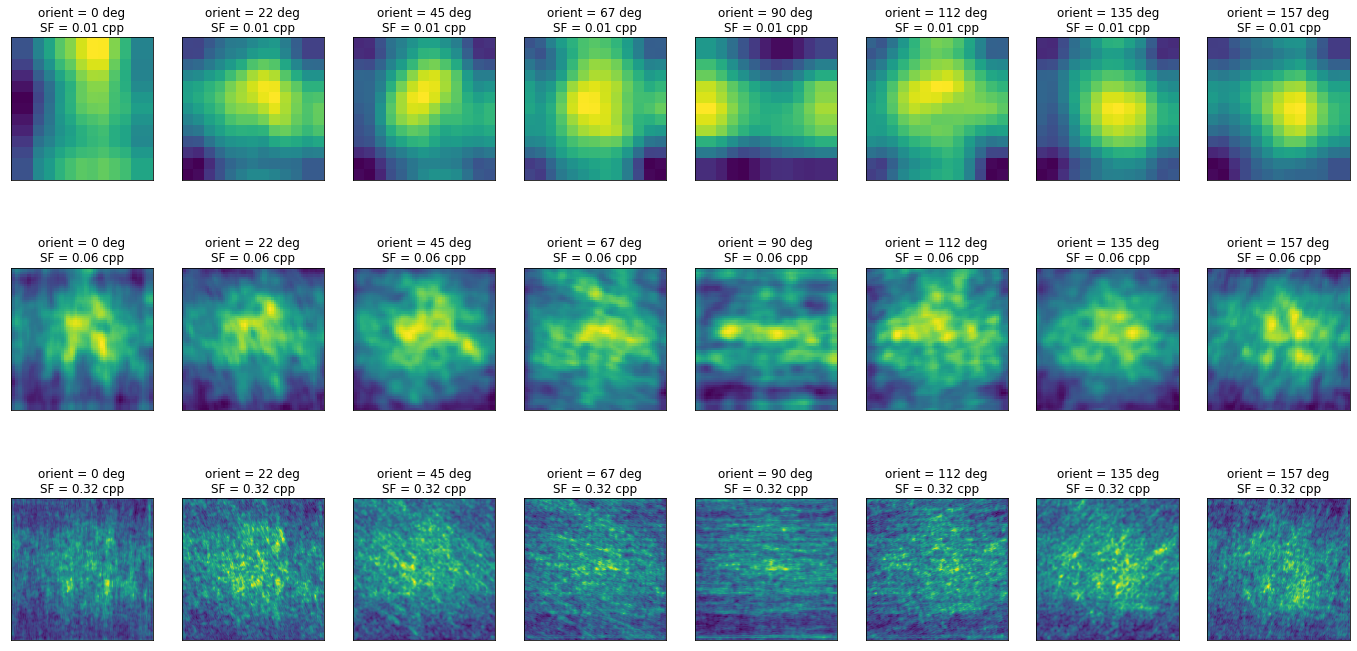

In [25]:
# plot average over maps for many images (want to see spatial distribution of energy)


plt.figure(figsize=(24,12))
for ff in range(np.shape(maps_spat)[3]):
    
    plt.subplot(3,8,ff+1)
    plt.pcolormesh(np.mean(maps_gab[freq_ind_list[ff]][:,orient_ind_list[ff],:,:], axis=0))
    plt.axis('square')
    plt.xticks([]); plt.yticks([])
    plt.title('orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))